# Optional Lab - Simple Neural Network
이번 실습에서는 Numpy를 사용하여 소규모 신경망을 구축해 보겠습니다. 이는 Tensorflow에서 구현한 것과 동일한 "커피 로스팅" 네트워크가 됩니다.
   <center> <img  src="./images/C2_W1_CoffeeRoasting.png" width="400" />   <center/>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from lab_utils_common import dlc, sigmoid
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## DataSet
이는 이전 실습과 동일한 데이터 세트입니다.

In [2]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


아래에 커피 로스팅 데이터를 그려보겠습니다. 두 가지 기능은 섭씨 온도와 분 단위의 지속 시간입니다. [Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/)에서는 온도가 12~15분 사이로 유지되는 것이 가장 좋다고 제안합니다. 섭씨 175도에서 260도 사이여야 합니다. 물론 온도가 올라가면 지속시간은 줄어들겠죠.

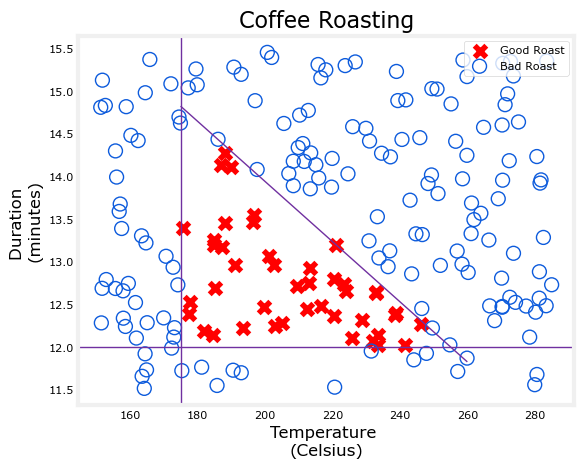

In [3]:
plt_roast(X,Y)

### Normalize Data
이전 실습과 일치시키기 위해 데이터를 정규화하겠습니다. 자세한 내용은 해당 실습을 참조하세요.

In [4]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51


2023-09-10 17:28:06.024857: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-10 17:28:06.024903: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-10 17:28:06.024915: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-10 17:28:06.024985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-10 17:28:06.025013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-10 17:28:06.163365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-10 17:28:06.174826: I t

Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


## Numpy Model (Forward Prop in NumPy)
<center> <img  src="./images/C2_W1_RoastingNetwork.PNG" width="200" />   <center/>  
강의에서 설명한 "커피 로스팅 네트워크"를 구축해 보겠습니다. 시그모이드 활성화를 사용하는 두 개의 레이어가 있습니다.

강의에서 설명했듯이 NumPy를 사용하여 자신만의 Dense Layer를 구축하는 것이 가능합니다. 그런 다음 이를 활용하여 다층 신경망을 구축할 수 있습니다.

<img src="images/C2_W1_dense2.PNG" width="600" height="450">

첫 번째 선택적 실습에서는 NumPy와 Tensorflow에서 뉴런을 구성하고 유사성을 확인했습니다. 레이어에는 단순히 여러 개의 뉴런/유닛이 포함되어 있습니다. 강의에서 설명했듯이 for 루프를 활용하여 레이어의 각 유닛(`j`)을 방문하고 해당 유닛(`W[:,j]`)에 대한 가중치의 내적을 수행하고 해당 유닛 (`b[j]`)에 대한 편향을 합산하여 `z`를 형성합니다. 그런 다음 활성화 함수 'g(z)'를 해당 결과에 적용할 수 있습니다. 아래에서 "dense layer" 서브루틴을 빌드해 보겠습니다.

In [5]:
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units|
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):               
        w = W[:,j]                                    
        z = np.dot(w, a_in) + b[j]         
        a_out[j] = g(z)               
    return(a_out)

다음 셀은 위의 `my_dense` 서브루틴을 활용하여 2계층 신경망을 구축합니다.

In [6]:
def my_sequential(x, W1, b1, W2, b2):
    a1 = my_dense(x,  W1, b1, sigmoid)
    a2 = my_dense(a1, W2, b2, sigmoid)
    return(a2)

Tensorflow 의 이전 실습에서 훈련된 가중치와 편향을 복사할 수 있습니다.

In [7]:
W1_tmp = np.array( [[-8.93,  0.29, 12.9 ], [-0.1,  -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28,  0.96] )
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.41] )

### Predictions
<img align="left" src="./images/C2_W1_RoastingDecision.PNG"     style=" width:380px; padding: 10px 20px; " >

훈련된 모델이 있으면 이를 사용하여 예측할 수 있습니다. 우리 모델의 출력은 확률이라는 것을 기억하세요. 이 경우에는 좋은 로스트가 나올 확률이 높습니다. 결정을 내리려면 확률을 임계값에 적용해야 합니다. 이 경우에는 0.5를 사용하겠습니다.

Tensorflow의 `model.predict()`와 유사한 루틴을 작성하는 것부터 시작해 보겠습니다. 이는 행의 모든 $m$ 예제가 포함된 행렬 $X$를 사용하고 모델을 실행하여 예측을 수행합니다.

In [8]:
def my_predict(X, W1, b1, W2, b2):
    m = X.shape[0]
    p = np.zeros((m,1))
    for i in range(m):
        p[i,0] = my_sequential(X[i], W1, b1, W2, b2)
    return(p)

다음 두 가지 예에서 이 루틴을 시도해 볼 수 있습니다.

In [9]:
X_tst = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_tstn = norm_l(X_tst)  # remember to normalize
predictions = my_predict(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp)

확률을 결정으로 변환하기 위해 임계값을 적용합니다.

In [10]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


이는 보다 간결하게 수행할 수 있습니다.

In [11]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Network function

이 그래프는 전체 네트워크의 작동을 보여주며 이전 실습의 Tensorflow 결과와 동일합니다.
왼쪽 그래프는 파란색 음영으로 표시되는 최종 레이어의 원시 출력입니다. 이는 X와 O로 표시되는 훈련 데이터 위에 중첩됩니다.
오른쪽 그래프는 결정 임계값 이후 네트워크의 출력입니다. 여기서 X와 O는 네트워크가 내린 결정에 해당합니다.This graph shows the operation of the whole network and is identical to the Tensorflow result from the previous lab.
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.   
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.  

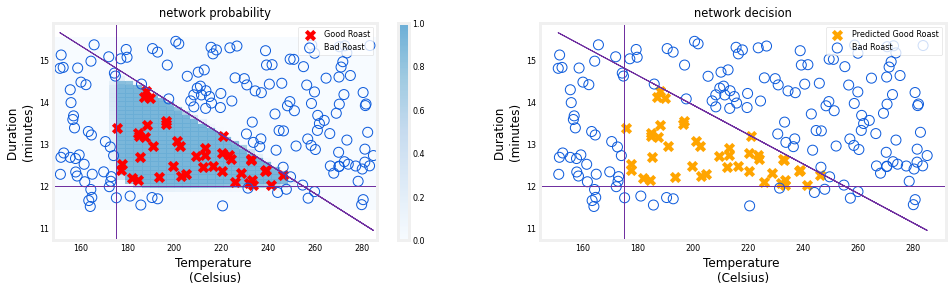

In [12]:
netf= lambda x : my_predict(norm_l(x),W1_tmp, b1_tmp, W2_tmp, b2_tmp)
plt_network(X,Y,netf)

## Congratulations!
You have built a small neural network in NumPy. 
Hopefully this lab revealed the fairly simple and familiar functions which make up a layer in a neural network. 